In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy import stats
import statsmodels.formula.api as smf
from pymer4.models import Lm, Lmer

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

# Simulate some data
Assume that there is a bold signal Y correlated within each subject to behavior x. h is a heterogenity factor that influences the variance of x. There is subject level noise in the relationship between x and Y. Assume proportional coding.

In [2]:
class SimulatedData(object):

    def __init__(self, n_subj=50, n_trials=50,
                 x_y_m=2, x_y_b=0, x_y_e=0,
                 h_y_m=0, hx_y_m = 0,
                 s_x_mvar=1, s_bvar=0.1,
                 s_h_mvar=0, s_hx_mvar=0,
                 varx_h_m=1, varx_h_b=1, varx_h_e=0):
        
        self.n_subj = n_subj
        self.n_trials = n_trials
        self.x_y_m = x_y_m
        self.x_y_b = x_y_b
        self.x_y_e = x_y_e
        self.h_y_m = h_y_m
        self.hx_y_m = hx_y_m
        self.s_x_mvar = s_x_mvar
        self.s_h_mvar = s_h_mvar
        self.s_hx_mvar = s_hx_mvar
        self.s_bvar = s_bvar
        self.varx_h_m = varx_h_m
        self.varx_h_b = varx_h_b
        self.varx_h_e = varx_h_e
        self.second_res = {}
        
        dat = []
        subj_x_ms = np.random.randn(n_subj) * s_x_mvar
        subj_bs = np.random.randn(n_subj) * s_bvar
        subj_h_ms = np.random.randn(n_subj) * s_h_mvar
        subj_hx_ms = np.random.randn(n_subj) * s_hx_mvar
        for subj in range(n_subj):
            h = np.random.binomial(1, 0.5)
            xs = np.random.randn(n_trials) * ((varx_h_m * h) + varx_h_b + (varx_h_e * np.random.randn(n_trials)))
            xs_std = (xs - xs.mean())/xs.std()
            x_term = ((x_y_m + subj_x_ms[subj]) * xs)
            hx_term = ((hx_y_m + subj_hx_ms[subj]) * (h*xs))
            h_term = ((h_y_m + subj_h_ms[subj]) * h)
            const_term = x_y_b + subj_bs[subj]
            ys =  x_term + hx_term + h_term + const_term + (x_y_e * np.random.randn(n_trials))
            for trial in range(n_trials):
                row = {}
                row['subj'] = subj
                row['trial'] = trial
                row['x'] = xs[trial]
                row['xstd'] = xs_std[trial]
                row['y'] = ys[trial]
                row['h'] = h
                dat.append(row)
        self.dat = pd.DataFrame(dat)
        self._run_first_level()
        self._run_second_level()

    def _run_first_level(self):
        fl_res = []
        for sx, df in self.dat.groupby('subj'):
            res = {}
            res['subj'] = sx
            res['h'] = df.iloc[0]['h']
            mod = smf.ols(formula='y ~ x', data=df)
            mres = mod.fit()
            res['b'] = mres.params['x']
            mod = smf.ols(formula='y ~ xstd', data=df)
            mres = mod.fit()
            res['b_std'] = mres.params['xstd']
            fl_res.append(res)
        self.first_res = pd.DataFrame(fl_res)
        
    def _run_second_level(self):
        
        sl_mod = smf.ols(formula='b ~ h', data = self.first_res)
        self.second_res['unstd'] = sl_mod.fit()
        sl_mod = smf.ols(formula='b_std ~ h', data = self.first_res)
        self.second_res['std'] = sl_mod.fit()

In [135]:
sd = SimulatedData()

In [ ]:
nsims = 100
sim_res = []
for sim in range(nsims):
    sd = SimulatedData()
    res = {}
    res['b_h'] = sd.second_res['unstd'].params['h']
    res['b_std_h'] = sd.second_res['std'].params['h']
    sim_res.append(res)
sim_res = pd.DataFrame(sim_res)

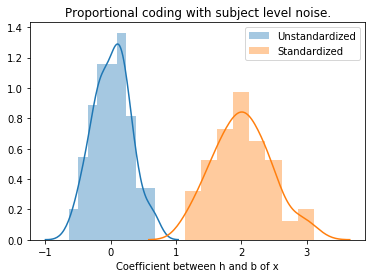

In [137]:
fig, ax = plt.subplots(1)
sns.distplot(sim_res.b_h, ax=ax, label='Unstandardized')
sns.distplot(sim_res.b_std_h, ax=ax, label='Standardized')
ax.set_xlabel('Coefficient between h and b of x')
ax.set_title("Proportional coding with subject level noise.")
ax.legend()

Yep, confirms the results for proportional coding from lebreton 

# Let's see if a mixed effects model helps

In [68]:
term_dict = {'x':1,
             'h1':0.2,
             'x:h1':0.5}

In [50]:

res = []
for sim in range(nsims):
    sd = SimulatedData(x_y_m = term_dict['x'], x_y_e=1, h_y_m=term_dict['h1'], hx_y_m=term_dict['x:h1'],
                       varx_h_m=1,  varx_h_e=2, s_h_mvar=1, s_hx_mvar=1)
    model = Lmer('y ~ x * h + (x|subj)', data=sd.dat)
    model.fit(factors={'h': [0,1]}, summarize=False, verbose=False)
    
    unstd = model.coefs
    unstd['standardized'] = False
    unstd['sim'] = sim
    if model.warnings is not None:
        if ('converge' in model.warnings) | np.any(['converge' in mw for mw in model.warnings]):
            unstd['converged'] = False
        else:
            break
    else:
        unstd['converged'] = True
        
    model = Lmer('y ~ xstd * h + (xstd|subj)', data=sd.dat)
    model.fit(factors={'h': [0,1]}, summarize=False, verbose=False)
    
    std = model.coefs
    std['standardized'] = True
    std['sim'] = sim
    if model.warnings is not None:
        if ('converge' in model.warnings) | np.any(['converge' in mw for mw in model.warnings]):
            std['converged'] = False
        else:
            break
    else:
        std['converged'] = True
    res.append(pd.concat([unstd, std]))

Model failed to converge with max|grad| = 0.00327169 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00558741 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00469009 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00400551 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00250704 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00272882 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00377355 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.0021261 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00456596 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00211594 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00248618 (tol = 0.002, component 1) 

Model failed to converge with max|grad| = 0.00212591 (tol = 0.002, component 1) 

Model failed to c

In [14]:
model.warnings

In [51]:
lme_res = pd.concat(res).reset_index().rename(columns={'index':'term'})

In [52]:
lme_res.loc[lme_res.term == 'xstd', 'term'] = 'x'
lme_res.loc[lme_res.term == 'xstd:h1', 'term'] = 'x:h1'

In [55]:
lme_res.groupby(['standardized', 'term']).mean()

Estimate    2.5_ci   97.5_ci        SE         DF  \
standardized term                                                             
False        (Intercept) -0.000331 -0.287132  0.286470  0.146330  47.987380   
             h1           0.165660 -0.236320  0.567641  0.205096  47.991778   
             x            1.014052  0.524169  1.503935  0.249945  48.079394   
             x:h1         0.496566 -0.191795  1.184927  0.351211  48.018422   
True         (Intercept)  0.004318 -0.396560  0.405197  0.204534  48.000068   
             h1           0.179137 -0.382793  0.741068  0.286704  48.000068   
             x            2.194017  0.893781  3.494253  0.663398  47.998769   
             x:h1         1.971706  0.145018  3.798395  0.932001  47.998770   

                            T-stat     P-val   sim  converged  
standardized term                                              
False        (Intercept) -0.001016  0.848063  49.5       0.89  
             h1           0.861599  0.387128  49.5       0.89  
             x            4.146796  0.003419  49.5       0.89  
             x:h1         1.421854  0.276622  49.5       0.89  
True         (Intercept)  0.010828  0.739856  49.5       0.78  
             h1           0.658826  0.448558  49.5       0.78  
             x            3.400439  0.009594  49.5       0.78  
             x:h1         2.119613  0.114351  49.5       0.78

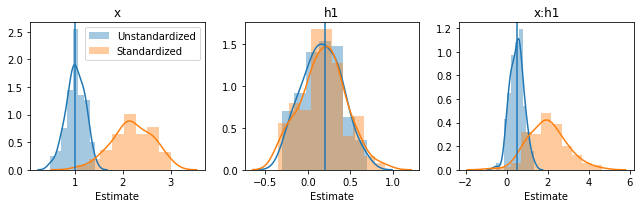

In [70]:
fig, axs = plt.subplots(1,3, figsize=(9,3))

for ii, (ax, t) in enumerate(zip(axs,['x', 'h1', 'x:h1'])):
    sns.distplot(lme_res.query('~standardized & term == @t')['Estimate'], label='Unstandardized', ax=ax)
    sns.distplot(lme_res.query('standardized & term == @t')['Estimate'], label='Standardized', ax=ax)
    ymin,ymax = ax.get_ylim()
    ax.axvline(term_dict[t], ymin, ymax)
    ax.set_ylim(ymin,ymax)
    ax.set_title(t)
    if ii == 0:
        ax.legend()
fig.tight_layout()